# Exploratory Data Analysis

## import packages

In [33]:
import pandas as pd

# viz
import plotly.express as px

## load train set

In [34]:
train = pd.read_csv("data/Train.csv")

In [35]:
# look at head
train.head(3)

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0


In [36]:
print("Number of observations: {}".format(train.shape[0]))
print("Number of unique labels: {}".format(train.label.nunique()))
print("The unique labels are: {0} and {1}".format(train.label.unique()[0],
                                                 train.label.unique()[1]))

Number of observations: 40000
Number of unique labels: 2
The unique labels are: 0 and 1


## look at example of a neg review

In [37]:
# get a negative review 
train.query('label == 0').text[0]

'I grew up (b. 1965) watching and loving the Thunderbirds. All my mates at school watched. We played "Thunderbirds" before school, during lunch and after school. We all wanted to be Virgil or Scott. No one wanted to be Alan. Counting down from 5 became an art form. I took my children to see the movie hoping they would get a glimpse of what I loved as a child. How bitterly disappointing. The only high point was the snappy theme tune. Not that it could compare with the original score of the Thunderbirds. Thankfully early Saturday mornings one television channel still plays reruns of the series Gerry Anderson and his wife created. Jonatha Frakes should hand in his directors chair, his version was completely hopeless. A waste of film. Utter rubbish. A CGI remake may be acceptable but replacing marionettes with Homo sapiens subsp. sapiens was a huge error of judgment.'

In [38]:
train.query('label == 0').text[1]

"When I put this movie in my DVD player, and sat down with a coke and some chips, I had some expectations. I was hoping that this movie would contain some of the strong-points of the first movie: Awsome animation, good flowing story, excellent voice cast, funny comedy and a kick-ass soundtrack. But, to my disappointment, not any of this is to be found in Atlantis: Milo's Return. Had I read some reviews first, I might not have been so let down. The following paragraph will be directed to those who have seen the first movie, and who enjoyed it primarily for the points mentioned.<br /><br />When the first scene appears, your in for a shock if you just picked Atlantis: Milo's Return from the display-case at your local videoshop (or whatever), and had the expectations I had. The music feels as a bad imitation of the first movie, and the voice cast has been replaced by a not so fitting one. (With the exception of a few characters, like the voice of Sweet). The actual drawings isnt that bad, 

## look at example of a pos review

In [39]:
# get a positive review 
train.query('label == 1').text.values[0]

'Im a die hard Dads Army fan and nothing will ever change that. I got all the tapes, DVD\'s and audiobooks and every time i watch/listen to them its brand new. <br /><br />The film. The film is a re run of certain episodes, Man and the hour, Enemy within the gates, Battle School and numerous others with a different edge. Introduction of a new General instead of Captain Square was a brilliant move - especially when he wouldn\'t cash the cheque (something that is rarely done now).<br /><br />It follows through the early years of getting equipment and uniforms, starting up and training. All in all, its a great film for a boring Sunday afternoon. <br /><br />Two draw backs. One is the Germans bogus dodgy accents (come one, Germans cant pronounced the letter "W" like us) and Two The casting of Liz Frazer instead of the familiar Janet Davis. I like Liz in other films like the carry ons but she doesn\'t carry it correctly in this and Janet Davis would have been the better choice.'

In [40]:
train.query('label == 1').text.values[1]

'Finally watched this shocking movie last night, and what a disturbing mindf**ker it is, and unbelievably bloody and some unforgettable scenes, and a total assault on the senses. Looks like a movie from the minds of Lynch (specifically ERASERHEAD), Buttgereit, and even a little of "Begotten". What this guy does to his pregnant sister is beyond belief, but then again, did it really happen or is it his brain\'s left and right sides doing battle. That\'s the main theme of this piece of art, to draw a fine line between fantasy and reality, and what would happen if the right side of the brain that dreams and fantasizes overtakes the reasoning and logical left side. And the music in this movie is unbelievable, a kind of electronic score that is absolutely perfect. Even though this movie is totally shocking and pretty disgusting in some of the most extreme scenes (including hard core sex) you will ever see in any movie, I viewed it as a work of art, and loved it. And that music still amazes m

**There are `html` tags present in the data here; this will have to be removed during data cleaning.**

## Visualize count of pos/neg

In [41]:
# how many positive/negative reviews are there? 
df = (train.groupby(by='label')
          .count()
          .reset_index()
          .rename(columns={'text':'count'}))

df['label'] = ['negative', 'positive']
df


,label,count
0,negative,20019
1,positive,19981


The visualization of positive vs negative review counts indicates a balanced dataset with
the count of positive reviews nearly equal to the count of negative reviews.

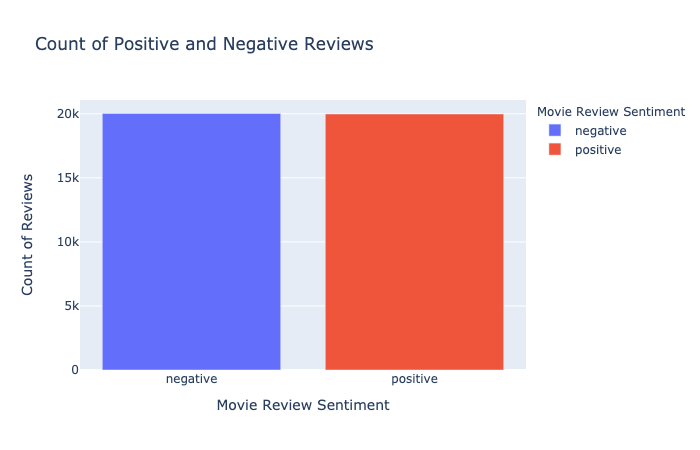

In [42]:
# plot he count of pos/neg labels
plot1 = px.bar(df,
       x='label',
       y='count',
       color='label',
       title='Count of Positive and Negative Reviews',
       labels={'label': 'Movie Review Sentiment',
               'count': 'Count of Reviews'})
plot1.show('png')